# Imports

In [69]:
import numpy as np
import pandas as pd
import GEOparse
import pylab as pl
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_ind
from bioinfokit import visuz
import matplotlib.pyplot as plt
pl.rcParams['figure.figsize'] = (14, 10)
pl.rcParams['ytick.labelsize'] = 12
pl.rcParams['xtick.labelsize'] = 11
pl.rcParams['axes.labelsize'] = 23
pl.rcParams['legend.fontsize'] = 20
sns.set_style('ticks')
c1, c2, c3, c4 = sns.color_palette("Set1", 4)
%matplotlib inline

# Load data

In [3]:
gse = GEOparse.get_GEO(geo="GSE26728", destdir="./")

05-Apr-2020 19:51:51 DEBUG utils - Directory ./ already exists. Skipping.
05-Apr-2020 19:51:51 INFO GEOparse - File already exist: using local version.
05-Apr-2020 19:51:51 INFO GEOparse - Parsing ./GSE26728_family.soft.gz: 
05-Apr-2020 19:51:51 DEBUG GEOparse - DATABASE: GeoMiame
05-Apr-2020 19:51:51 DEBUG GEOparse - SERIES: GSE26728
05-Apr-2020 19:51:51 DEBUG GEOparse - PLATFORM: GPL7042
/home/daniel/.local/share/virtualenvs/gene-differentiation-vXDgkjxa/lib/python3.7/site-packages/GEOparse/GEOparse.py:104: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  return parse_GSE(filepath)
05-Apr-2020 19:51:52 DEBUG GEOparse - SAMPLE: GSM658075
05-Apr-2020 19:51:52 DEBUG GEOparse - SAMPLE: GSM658076
05-Apr-2020 19:51:52 DEBUG GEOparse - SAMPLE: GSM658077
05-Apr-2020 19:51:52 DEBUG GEOparse - SAMPLE: GSM658078
05-Apr-2020 19:51:52 DEBUG GEOparse - SAMPLE: GSM658079
05-Apr-2020 19:51:53 DEBUG GEOparse - SAMPLE: GSM658080
05-Apr-2020 19:51:53 

In [4]:
CONTROLS = ['GSM658075', 'GSM658076', 'GSM658077', 
            'GSM658078', 'GSM658079', 'GSM658080']
LOW_DOSE = ['GSM658081', 'GSM658082', 'GSM658083', 
            'GSM658084', 'GSM658085', 'GSM658086']
HIGH_DOSE = ['GSM658087', 'GSM658088', 'GSM658089', 
             'GSM658090', 'GSM658091', 'GSM658092']

# Explore data

In [5]:
info = gse.gpls['GPL7042'].table        # gene info
num_all = info['SEQUENCE'].count()      # number of all sequenced genes

expression = gse.pivot_samples('VALUE') # log2 gene expression values
expression

name,GSM658075,GSM658076,GSM658077,GSM658078,GSM658079,GSM658080,GSM658081,GSM658082,GSM658083,GSM658084,GSM658085,GSM658086,GSM658087,GSM658088,GSM658089,GSM658090,GSM658091,GSM658092
ID_REF,,,,,,,,,,,,,,,,,,
A_51_P100034,12.630,11.899,12.393,12.539,12.368,12.361,12.332,12.148,12.032,11.955,12.222,12.202,12.107,12.529,11.838,12.054,12.223,12.343
A_51_P100063,5.828,6.598,5.984,5.986,6.089,6.163,6.384,6.410,5.984,6.158,6.031,5.833,6.441,7.814,6.107,7.017,5.853,6.656
A_51_P100099,7.638,7.635,7.216,7.767,7.516,7.378,7.171,7.558,7.571,7.607,7.523,7.628,7.461,7.321,7.792,7.577,7.412,7.357
A_51_P100155,10.947,10.582,10.406,11.054,10.770,10.402,10.610,10.512,10.492,10.485,10.839,10.535,10.674,10.333,10.622,10.302,10.339,10.572
A_51_P100174,6.632,6.089,6.012,6.190,6.260,6.131,5.993,6.274,6.002,6.011,6.124,6.062,6.375,6.087,6.152,6.202,6.209,6.172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A_52_P997209,7.734,8.105,7.841,7.631,7.893,8.232,7.570,8.146,7.550,7.820,7.648,7.675,7.763,8.154,7.703,7.878,8.058,7.989
A_52_P997449,10.070,9.784,9.009,10.071,9.762,9.535,9.876,9.999,10.084,10.064,10.219,10.133,9.428,9.136,9.890,10.302,10.493,9.447
A_52_P99807,8.176,7.628,7.993,7.717,6.355,6.668,6.699,7.256,6.803,8.208,8.409,7.008,6.384,8.434,6.441,6.719,6.401,7.256


In [6]:
expression.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22514 entries, A_51_P100034 to A_52_P99888
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GSM658075  22514 non-null  float64
 1   GSM658076  22514 non-null  float64
 2   GSM658077  22514 non-null  float64
 3   GSM658078  22514 non-null  float64
 4   GSM658079  22514 non-null  float64
 5   GSM658080  22514 non-null  float64
 6   GSM658081  22514 non-null  float64
 7   GSM658082  22514 non-null  float64
 8   GSM658083  22514 non-null  float64
 9   GSM658084  22514 non-null  float64
 10  GSM658085  22514 non-null  float64
 11  GSM658086  22514 non-null  float64
 12  GSM658087  22514 non-null  float64
 13  GSM658088  22514 non-null  float64
 14  GSM658089  22514 non-null  float64
 15  GSM658090  22514 non-null  float64
 16  GSM658091  22514 non-null  float64
 17  GSM658092  22514 non-null  float64
dtypes: float64(18)
memory usage: 3.3+ MB


In [7]:
info

,ID,SPOT_ID,CONTROL_TYPE,REFSEQ,GB_ACC,GENE,GENE_SYMBOL,GENE_NAME,UNIGENE_ID,ENSEMBL_ID,TIGR_ID,ACCESSION_STRING,CHROMOSOMAL_LOCATION,CYTOBAND,DESCRIPTION,GO_ID,SEQUENCE
0,A_51_P100021,A_51_P100021,False,NaN,AY454345,16656.0,Hivep3,human immunodeficiency virus type I enhancer b...,Mm.302758,NaN,NaN,gb|AY454345|tc|TC1584815|nap|NAP057482-1,chr4:119807944-119808005,mm|4qD2.1,Mus musculus clone pZAS3 328-2275 zinc finger ...,GO:0003676(nucleic acid binding)|GO:0003677(DN...,CATGGCTGGATTAACGTATGTGTGTGGTATATAGATACACAGAGAG...
1,A_51_P100034,A_51_P100034,False,NM_027162,NM_027162,69674.0,Mif4gd,MIF4G domain containing,Mm.390387,NaN,NaN,ref|NM_027162|ref|NM_001243586|ref|NM_00124358...,chr11:115469328-115469269,mm|11qE2,"Mus musculus MIF4G domain containing (Mif4gd),...",GO:0005488(binding)|GO:0005575(cellular_compon...,GAGACTTTTGTGGAGGAAGCCTGTTTCCTCCAGTCATGAGTGACTG...
2,A_51_P100052,A_51_P100052,False,NM_198863,NM_198863,245450.0,Slitrk2,"SLIT and NTRK-like family, member 2",Mm.336081,ENSMUST00000036043,NaN,ref|NM_198863|ref|NM_001161431|ens|ENSMUST0000...,chrX:63908145-63908204,mm|XqA7.1,"Mus musculus SLIT and NTRK-like family, member...",GO:0003674(molecular_function)|GO:0007409(axon...,CTAAATGTGAATTGCCAAGAAAGGAAGTTCACTAACATCTCTGACC...
3,A_51_P100063,A_51_P100063,False,NM_010727,NM_010727,16924.0,Lnx1,ligand of numb-protein X 1,Mm.440403,NaN,NaN,ref|NM_010727|ref|NM_001159577|ref|NM_00115957...,chr5:74993810-74993386,mm|5qC3.3,Mus musculus ligand of numb-protein X 1 (Lnx1)...,GO:0004842(ubiquitin-protein ligase activity)|...,GAAGAATCAGATGTGGTGACATTCTTCTCGCTGTCAACGGTAGAAG...
4,A_51_P100084,A_51_P100084,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nap|NAP091803-1,unmapped,NaN,NaN,NaN,AAGTCATCTCTCATGCCTATCAGAATACTCTGCCTCTAAGCCCAAA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41242,E1A_r60_n11,CONTROL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41243,E1A_r60_n9,CONTROL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41244,EQC,CONTROL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41245,NegativeControl,CONTROL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41247 entries, 0 to 41246
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    41246 non-null  object 
 1   SPOT_ID               41246 non-null  object 
 2   CONTROL_TYPE          41233 non-null  object 
 3   REFSEQ                28533 non-null  object 
 4   GB_ACC                39179 non-null  object 
 5   GENE                  34907 non-null  float64
 6   GENE_SYMBOL           34907 non-null  object 
 7   GENE_NAME             34907 non-null  object 
 8   UNIGENE_ID            35457 non-null  object 
 9   ENSEMBL_ID            28610 non-null  object 
 10  TIGR_ID               0 non-null      float64
 11  ACCESSION_STRING      40832 non-null  object 
 12  CHROMOSOMAL_LOCATION  41174 non-null  object 
 13  CYTOBAND              40390 non-null  object 
 14  DESCRIPTION           39659 non-null  object 
 15  GO_ID              

In [9]:
num_tracked = len(expression)         
num_tracked_unique = len(expression.index.unique())

print('Genes tracked: ', num_tracked)
print('Unique genes tracked: ', num_tracked_unique)

Genes tracked:  22514
Unique genes tracked:  22514


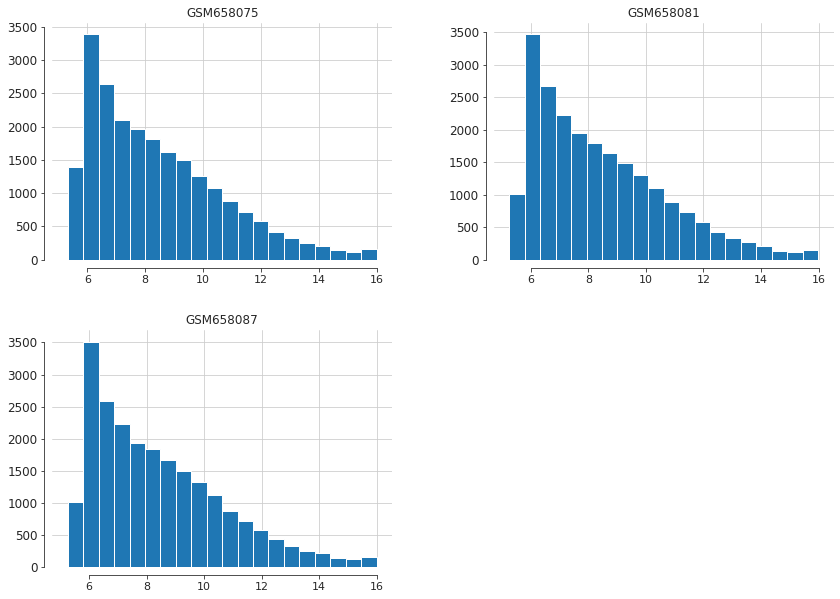

In [10]:
expression[[CONTROLS[0], LOW_DOSE[0], HIGH_DOSE[0]]].hist(bins=20)
sns.despine(offset=8, trim=True)

# Calculate avarages for controls, low_dose, high_dose

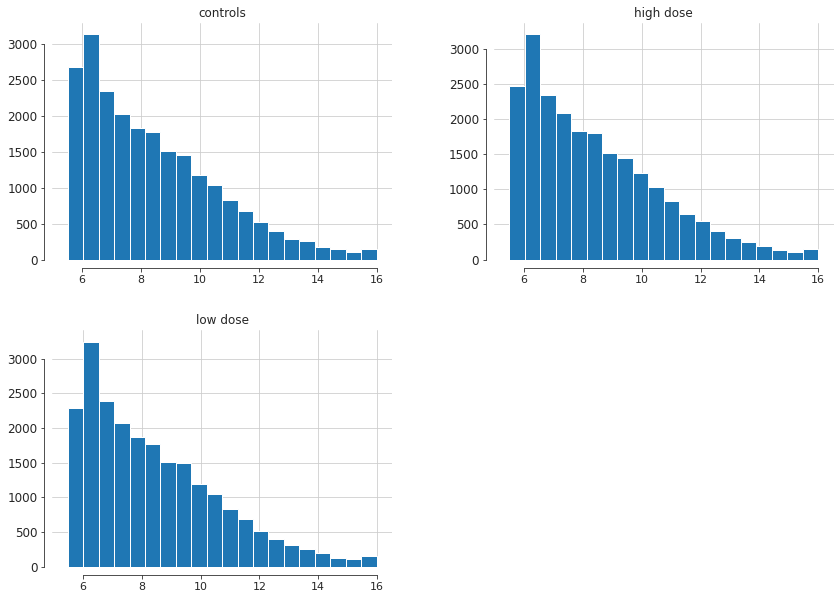

In [11]:
avg_expression = pd.concat([expression[CONTROLS].mean(axis=1).rename('controls'), 
                            expression[LOW_DOSE].mean(axis=1).rename('low dose'),
                            expression[HIGH_DOSE].mean(axis=1).rename('high dose')], 
                           axis=1)
avg_expression.hist(bins=20)
sns.despine(offset=8, trim=True)

# Volcano plots for `control vs low dose` and `control vs high dose`

In [110]:
low_dose_p_vals = []
high_dose_p_vals = []
for i in range(num_tracked):
    control_ = expression.iloc[i][CONTROLS].to_numpy()
    low_dose_ = expression.iloc[i][LOW_DOSE].to_numpy()
    high_dose_ = expression.iloc[i][HIGH_DOSE].to_numpy()
    
    tset, pval = ttest_ind(control_, low_dose_)
    low_dose_p_vals.append(pval)
    
    tset, pval = ttest_ind(control_, high_dose_)
    high_dose_p_vals.append(pval)

Volcano plot for control vs. low dose


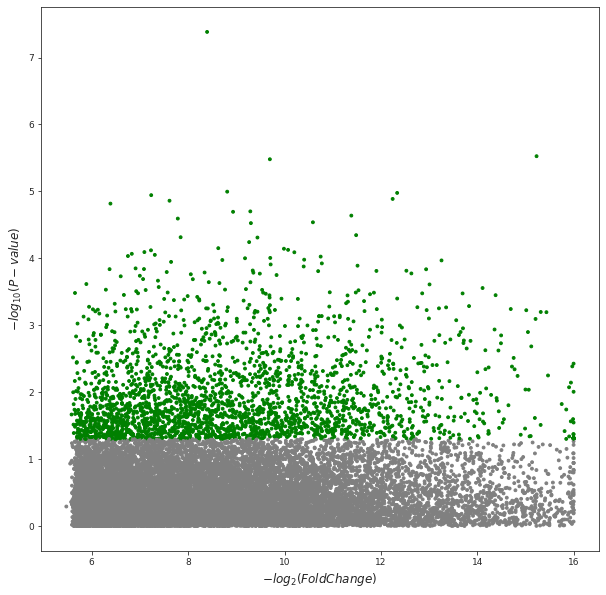

In [111]:
avg_with_pvals = pd.concat(
    [avg_expression, 
     pd.Series(low_dose_p_vals, index=avg_expression.index).rename('low dose p-value'), 
     pd.Series(high_dose_p_vals, index=avg_expression.index).rename('high dose p-value')],
    axis=1
)

print('Volcano plot for control vs. low dose')
visuz.gene_exp.volcano(d=avg_with_pvals, lfc='low dose', 
                       pv='low dose p-value', dim=(10, 10), show=True)

In [112]:
print('Top 5 -log(p_value) for control vs low dose')
top_5_logPV = avg_with_pvals.logpv.nlargest(5)
avg_with_pvals.loc[list(top_5_logPV.index)]

Top 5 -log(p_value) for control vs low dose


,controls,low dose,high dose,low dose p-value,high dose p-value,color,logpv
ID_REF,,,,,,,
A_51_P271887,7.232500,8.393667,7.351167,4.145603e-08,0.423062,green,7.382412
A_51_P194099,12.304333,15.225833,13.652667,2.980717e-06,0.026668,green,5.525679
A_51_P334804,8.061500,9.695333,8.398500,3.310431e-06,0.248486,green,5.480115
A_51_P286373,8.488333,8.810667,8.598667,1.009375e-05,0.094844,green,4.995947
A_52_P100252,10.026833,12.335167,10.711500,1.053691e-05,0.086269,green,4.977287


Volcano plot for control vs. high dose


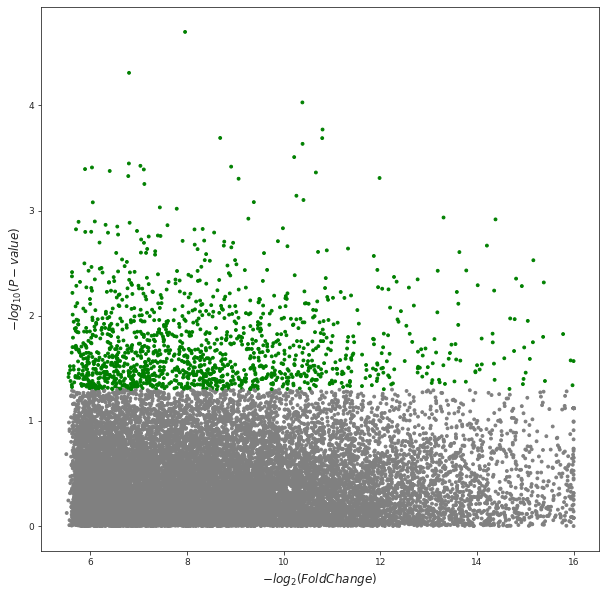

In [114]:
try:
    del avg_with_pvals['logpv']
    del avg_with_pvals['color']
except KeyError:
    print('logpv or color not found, continuing...')

print('Volcano plot for control vs. high dose')
visuz.gene_exp.volcano(d=avg_with_pvals, lfc='high dose', 
                       pv='high dose p-value', dim=(10, 10), show=True)

In [115]:
print('Top 5 -log(p_value) for control vs high dose')
top_5_logPV = avg_with_pvals.logpv.nlargest(5)
avg_with_pvals.loc[list(top_5_logPV.index)]

Top 5 -log(p_value) for control vs high dose


,controls,low dose,high dose,low dose p-value,high dose p-value,color,logpv
ID_REF,,,,,,,
A_51_P130544,8.484667,8.236667,7.959167,0.041793,0.000020,green,4.699880
A_52_P184435,7.302000,6.885833,6.800000,0.025982,0.000049,green,4.310660
A_52_P523179,11.125833,10.463833,10.385667,0.013965,0.000093,green,4.029243
A_51_P180492,9.043667,9.180000,10.802833,0.800414,0.000169,green,3.771539
A_51_P176681,9.432333,8.837167,8.685667,0.015534,0.000203,green,3.691459


# Find the differences in gene expression between groups

In this task it is required to build two decision trees to classify `control vs. low dose` and `control vs. high dose`. Then it is needed to find which features were assigned the highest importance value by the trees. 

Considering that this dataset consists of 22514 features and only 18 training examples (6 per group), applying decision tree on it's entirety wouldn't achieve much. The tree would just find the first feature it can split the dataset on (which there're plenty of), and the gene with the highest deffirence in expression would very likely be lost. The proposed solution addresses this issue by first removing the features with low variance and then applying an extra tree classifier to better evaluate the importances of the features.

In [12]:
def prepare_data(compare_to='low dose'):
    """Returns X and y for control and the group 
       passed in parameter compare_to"""
    X = None
    labels = len(CONTROLS)*['control']
    index = CONTROLS
    
    if compare_to == 'low dose':
        X = expression[CONTROLS + LOW_DOSE]
        labels += len(LOW_DOSE) * ['low dose']
        index = index + LOW_DOSE
    elif compare_to == 'high dose':
        X = expression[CONTROLS + HIGH_DOSE]
        labels += len(HIGH_DOSE) * ['high dose']
        index = index + HIGH_DOSE
    else:
        raise ValueError('compare_to can be either "low dose" or "high dose"')
    
    y = pd.DataFrame(labels, index=index,
                     columns=['control'])
    y['control'] = pd.get_dummies(y['control'])
    y = y.squeeze()
    return X.T, y

In [13]:
def top_twenty_features(feature_names, importances):
    """Zips names and importances together and returns
       20 features with the highest importance"""
    sorted_pairs = sorted(zip(feature_names, importances), 
                          key=lambda x: x[1], 
                          reverse=True)
    return list(sorted_pairs)[:20]

# Naive solution

In the following example we can see, that one decision tree applied to the whole dataset just finds the first feature it can split it on

In [14]:
X, y = prepare_data(compare_to='low dose')

clf = DecisionTreeClassifier(random_state=0, max_depth=2) 
clf.fit(X, y)

print('Prediction: first half - control, second half - low dose:', clf.predict(X))
print('All the importance goes to A_51_P112322...')
top_twenty_features(X.columns, clf.feature_importances_)

Prediction: first half - control, second half - low dose: [1 1 1 1 1 1 0 0 0 0 0 0]
All the importance goes to A_51_P112322...


[('A_51_P112322', 1.0),
 ('A_51_P100034', 0.0),
 ('A_51_P100063', 0.0),
 ('A_51_P100099', 0.0),
 ('A_51_P100155', 0.0),
 ('A_51_P100174', 0.0),
 ('A_51_P100181', 0.0),
 ('A_51_P100227', 0.0),
 ('A_51_P100246', 0.0),
 ('A_51_P100289', 0.0),
 ('A_51_P100327', 0.0),
 ('A_51_P100470', 0.0),
 ('A_51_P100505', 0.0),
 ('A_51_P100565', 0.0),
 ('A_51_P100573', 0.0),
 ('A_51_P100625', 0.0),
 ('A_51_P100787', 0.0),
 ('A_51_P100828', 0.0),
 ('A_51_P100852', 0.0),
 ('A_51_P100856', 0.0)]

In [15]:
print('...while there\'re genes with more significant changes in expression, e.g. A_52_P100252:\n')
print(pd.concat((X['A_51_P112322'], X['A_52_P100252']), axis=1))

print('\nAlso, changing the random state changes the most important feature:')
clf = DecisionTreeClassifier(random_state=123, max_depth=2) 
clf.fit(X, y)

top_twenty = top_twenty_features(X.columns, clf.feature_importances_)
print('With random_state=123, the most important feature is {}'.format(top_twenty[0][0]))
top_twenty

...while there're genes with more significant changes in expression, e.g. A_52_P100252:

           A_51_P112322  A_52_P100252
name                                 
GSM658075         7.582         9.674
GSM658076         7.635         9.960
GSM658077         7.421        10.343
GSM658078         7.683        10.086
GSM658079         7.469        10.031
GSM658080         7.653        10.067
GSM658081         8.223        13.365
GSM658082         8.146        11.886
GSM658083         7.832        12.269
GSM658084         7.895        11.540
GSM658085         7.995        12.113
GSM658086         7.852        12.838

Also, changing the random state changes the most important feature:
With random_state=123, the most important feature is A_52_P480709


[('A_52_P480709', 1.0),
 ('A_51_P100034', 0.0),
 ('A_51_P100063', 0.0),
 ('A_51_P100099', 0.0),
 ('A_51_P100155', 0.0),
 ('A_51_P100174', 0.0),
 ('A_51_P100181', 0.0),
 ('A_51_P100227', 0.0),
 ('A_51_P100246', 0.0),
 ('A_51_P100289', 0.0),
 ('A_51_P100327', 0.0),
 ('A_51_P100470', 0.0),
 ('A_51_P100505', 0.0),
 ('A_51_P100565', 0.0),
 ('A_51_P100573', 0.0),
 ('A_51_P100625', 0.0),
 ('A_51_P100787', 0.0),
 ('A_51_P100828', 0.0),
 ('A_51_P100852', 0.0),
 ('A_51_P100856', 0.0)]

# Solution with feature selection and decision forests

Create a pipeline, that selects features and then fits an extra trees classifier

In [16]:
X_low, y_low = prepare_data(compare_to='low dose')

feature_selector = VarianceThreshold(threshold=1) 
forest = ExtraTreesClassifier(n_estimators=1000, 
                              max_depth=2, 
                              random_state=0)
pipeline = Pipeline([('feature_selector', feature_selector), 
                     ('forest', forest)])
pipeline.fit(X_low, y_low)
selector_mask = pipeline.named_steps.feature_selector.get_support()
selected_features_low = X_low.columns.to_numpy()[selector_mask]

print('Reduced the number of features to {}\n'.format(np.sum(selector_mask)))

Reduced the number of features to 121



Find out what the most important features are for `control vs low dose`, and check if they depend on random state.

In [17]:
top_twenty_low = top_twenty_features(
    selected_features_low, 
    pipeline.named_steps.forest.feature_importances_
)
top_twenty_names_low = set(map(lambda x: x[0], top_twenty_low))
print('Most important features for control vs. low dose (unordered):\n')
print('random state = 0\n{}\n'.format(top_twenty_names_low))

seed = 123
pipeline.set_params(forest__random_state=seed)
pipeline.fit(X_low, y_low)
top_twenty2 = top_twenty_features(
    selected_features_low, 
    pipeline.named_steps.forest.feature_importances_
)
top_twenty_names2 = set(map(lambda x: x[0], top_twenty2))
print('random state = {}\n{}'.format(seed, top_twenty_names2))

print('\nIn order:')
top_twenty_low

Most important features for control vs. low dose (unordered):

random state = 0
{'A_51_P194099', 'A_51_P217498', 'A_51_P206736', 'A_51_P453043', 'A_51_P389265', 'A_51_P510156', 'A_51_P463440', 'A_52_P100252', 'A_51_P337308', 'A_51_P209183', 'A_51_P491075', 'A_51_P253481', 'A_51_P472659', 'A_52_P350750', 'A_52_P161495', 'A_52_P384392', 'A_52_P658945', 'A_52_P245962', 'A_51_P261718', 'A_52_P21486'}

random state = 123
{'A_51_P194099', 'A_51_P217498', 'A_51_P453043', 'A_51_P389265', 'A_51_P510156', 'A_51_P463440', 'A_52_P100252', 'A_51_P209183', 'A_51_P491075', 'A_51_P476767', 'A_51_P253481', 'A_51_P468558', 'A_51_P472659', 'A_52_P350750', 'A_52_P161495', 'A_52_P384392', 'A_52_P658945', 'A_52_P245962', 'A_51_P261718', 'A_52_P21486'}

In order:


[('A_51_P389265', 0.07640660997732422),
 ('A_51_P194099', 0.06630384615384617),
 ('A_52_P100252', 0.062045178710178686),
 ('A_52_P350750', 0.05289744897959183),
 ('A_51_P261718', 0.05288099091384805),
 ('A_51_P453043', 0.043435192743764166),
 ('A_52_P658945', 0.03844492412349555),
 ('A_51_P463440', 0.03707733805876664),
 ('A_52_P384392', 0.03361958364867455),
 ('A_51_P209183', 0.026055228580942863),
 ('A_52_P161495', 0.02424512471655329),
 ('A_51_P253481', 0.01797822954822955),
 ('A_52_P245962', 0.017902057010095014),
 ('A_51_P217498', 0.017681632895582472),
 ('A_51_P491075', 0.015998374324088616),
 ('A_51_P472659', 0.01514308802308802),
 ('A_51_P337308', 0.014487301587301594),
 ('A_51_P510156', 0.013669863469863472),
 ('A_52_P21486', 0.013350342206357784),
 ('A_51_P206736', 0.012840659340659344)]

Features that are found to be the most important: coparison between `control vs low dose` and `control vs high dose` 

In [18]:
X_high, y_high = prepare_data(compare_to='high dose')
pipeline.fit(X_high, y_high)

selector_mask = pipeline.named_steps.feature_selector.get_support()
selected_features_high = X_low.columns.to_numpy()[selector_mask]

print('Reduced the number of features to {}\n'.format(np.sum(selector_mask)))

top_twenty_high = top_twenty_features(
    selected_features_high, 
    pipeline.named_steps.forest.feature_importances_
)
top_twenty_names_high = set(map(lambda x: x[0], top_twenty_high))

matching_features = top_twenty_names_low & top_twenty_names_high
print('Matching important features: ', matching_features)

print('\nMost important features for control vs. high dose:')
top_twenty_high

Reduced the number of features to 171

Matching important features:  {'A_51_P194099', 'A_51_P491075', 'A_51_P389265'}

Most important features for control vs. high dose:


[('A_51_P180492', 0.05913072387929529),
 ('A_51_P439645', 0.050814559250273554),
 ('A_52_P271200', 0.04906540816326533),
 ('A_52_P131423', 0.04103889404246547),
 ('A_52_P542860', 0.0381790703694065),
 ('A_51_P491075', 0.032443047195568196),
 ('A_52_P257774', 0.02379139236665211),
 ('A_51_P468558', 0.023209494949494956),
 ('A_51_P389265', 0.022317439386010815),
 ('A_51_P209782', 0.01885537589394733),
 ('A_52_P605419', 0.018027992012655883),
 ('A_51_P377154', 0.016420774067202642),
 ('A_52_P50623', 0.014690022561979087),
 ('A_51_P315904', 0.014384697929999225),
 ('A_52_P246252', 0.01343946093588951),
 ('A_51_P470715', 0.013367856587856589),
 ('A_51_P194099', 0.012376181987946695),
 ('A_51_P311958', 0.01208884313632213),
 ('A_52_P9703', 0.011887063492063496),
 ('A_51_P249286', 0.011793858363858371)]

In [19]:
print('Expression:')
print(expression.T[matching_features])
print('\nGene info:')
info[info.ID.isin(matching_features)] 

Expression:
ID_REF     A_51_P194099  A_51_P491075  A_51_P389265
name                                               
GSM658075        11.501        11.599         7.793
GSM658076        12.050        10.509         8.101
GSM658077        12.749        11.776         9.582
GSM658078        12.243        11.962         8.192
GSM658079        12.190         9.251         8.358
GSM658080        13.093        10.465         8.477
GSM658081        15.984         8.751        13.866
GSM658082        14.850         9.729        11.774
GSM658083        15.030         5.528        11.901
GSM658084        14.756         5.550        11.979
GSM658085        14.933        10.942        10.988
GSM658086        15.802         9.872        12.942
GSM658087        12.526         7.796         8.745
GSM658088        14.282         5.414        11.715
GSM658089        12.738         8.772         7.987
GSM658090        15.073         9.011        11.928
GSM658091        12.642         9.923         8.042


,ID,SPOT_ID,CONTROL_TYPE,REFSEQ,GB_ACC,GENE,GENE_SYMBOL,GENE_NAME,UNIGENE_ID,ENSEMBL_ID,TIGR_ID,ACCESSION_STRING,CHROMOSOMAL_LOCATION,CYTOBAND,DESCRIPTION,GO_ID,SEQUENCE
4244,A_51_P194099,A_51_P194099,False,NM_009381,NM_009381,21835.0,Thrsp,thyroid hormone responsive SPOT14 homolog (Rat...,Mm.28585,ENSMUST00000043077,NaN,ref|NM_009381|ens|ENSMUST00000043077|gb|BC0091...,chr7:104565621-104565562,mm|7qE1,Mus musculus thyroid hormone responsive SPOT14...,GO:0005515(protein binding)|GO:0005634(nucleus...,GACCCGGAAAGCACAGGAGGTGACGCGGAAATACCAGGAAATGACA...
13143,A_51_P389265,A_51_P389265,False,NM_054088,NM_054088,116939.0,Pnpla3,patatin-like phospholipase domain containing 3,Mm.390817,ENSMUST00000045289,NaN,ref|NM_054088|ens|ENSMUST00000045289|gb|AY0377...,chr15:84019823-84019882,mm|15qE2,Mus musculus patatin-like phospholipase domain...,GO:0004623(phospholipase A2 activity)|GO:00048...,GCAAACTAGTGGAACAGCAGAAGGATTGAATGGATACACCAAAAAT...
17827,A_51_P491075,A_51_P491075,False,NM_028948,NM_028948,74453.0,Ccdc11,coiled-coil domain containing 11,Mm.182293,ENSMUST00000169586,NaN,ref|NM_028948|ref|NR_029424|ens|ENSMUST0000016...,chr18:74519376-74519435,mm|18qE2,Mus musculus coiled-coil domain containing 11 ...,GO:0003674(molecular_function)|GO:0005575(cell...,AGGGGTTACCCTGACAAGCCTCCTCTATAGTTTTATATAAATCAAT...
